## Part 2A: Discrete shape analysis

In this notebook, we will learn the basics of shape analysis on landmarked data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

### 0. Data loading

**0.1** Run the lines below to load the object models dataset.

In [2]:
# BBBC010
directory = 'data/BBBC010/masks'
point_models=np.load(os.path.join(directory,'point_models.npy'))

**0.2** Visualize a set of a few randomly selected models from the collection.

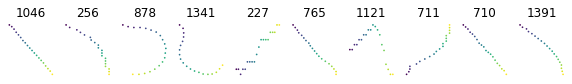

In [3]:
# Your turn!
number=10
inds=np.random.choice(len(point_models)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(number,1))
for i in range(0,number):
    point_model=np.array(point_models[inds[i]])
    t=np.arange(len(point_model))
    ax[i].scatter(point_model[:,0],point_model[:,1],s=.5,c=t,cmap='viridis')
    ax[i].set_title(str(inds[i]))
    ax[i].axis('off')

### 1. Procrustes alignment

**1.1** Center and scale the data such that they are all located around (0,0) and are of unit norm.

In [4]:
# Your turn!
preshapes=np.zeros(point_models.shape)

for i in range(len(point_models)):
    point_model=point_models[i]
    
    centroid=np.mean(point_model,0)
    centered=point_model-centroid
    
    scaled=centered/np.linalg.norm(centered)
    preshapes[i]=scaled

**1.2** Write a function that aligns one object model onto another reference one, assuming that the models are in correspondence†.

This problem can be formulated as finding the optimal rotation angle such that the distance between the two point sets is minimal.

*Hint: use ``scipy.optimize`` to carry out the optimization*

† This assumption is not necessarily biologically correct in the present case. Do you understand why? What is missing from the data preparation pipeline for it to hold?

In [5]:
import scipy.optimize

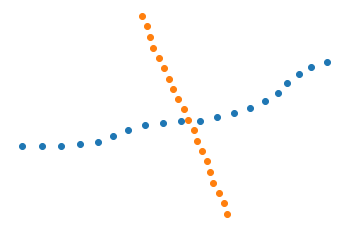

In [6]:
# Your turn!
# Pick two random models and try to align them
random=np.random.choice(len(point_models)-1, size=2, replace=False)
plt.scatter(preshapes[random[0]][:,0],preshapes[random[0]][:,1])
plt.scatter(preshapes[random[1]][:,0],preshapes[random[1]][:,1])
plt.axis('off')
plt.show()

In [7]:
# Define the objective function
def objectiveFunctionAlignment(theta, m1, m2):
    R=np.array([[np.cos(theta[0]),-np.sin(theta[0])],[np.sin(theta[0]),np.cos(theta[0])]])
    rotated_m2=R.dot(m2.T).T
    error=np.linalg.norm(m1-rotated_m2)
    rmse=np.sqrt(np.mean(error**2))
    return rmse

In [8]:
# Optimize
res=scipy.optimize.minimize(objectiveFunctionAlignment,0,args=(preshapes[random[0]],preshapes[random[1]]),method="L-BFGS-B")
theta0=res.x[0]

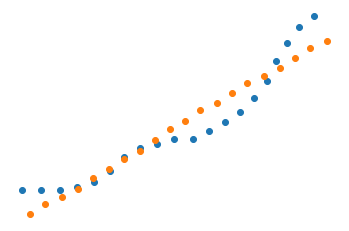

In [9]:
# Visualize the alignment
plt.scatter(preshapes[random[0]][:,0],preshapes[random[0]][:,1])

R=np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])
aligned=R.dot(preshapes[random[1]].T).T

plt.scatter(aligned[:,0],aligned[:,1])
plt.axis('off')
plt.show()

### 2. Kendall shape space

**2.1** Each input shape can be seen as a vector of complex numbers and associated with an appropriate Hermitian inner product. The lines below transforms your aligned shape dataset into complex vectors. Convince yourself that the "vector of complex numbers" representation is equivalent to the "vector of points" one.

In [10]:
complex_preshapes=preshapes[:,:,0] + 1j*preshapes[:,:,1]

**2.2** The function below computes the Fréchet mean of a dataset relying on complex number representations. Use it to extract the Fréchet mean of your data and visualize it.

In [11]:
def meanFrechet(input_complex_preshapes): # preshapes
    '''Input: dataset of complex preshapes.
    Output: Fréchet mean (w.r.t. the Procrustes distance).'''
    N=input_complex_preshapes.shape[1]
    SQ = input_complex_preshapes.T @ input_complex_preshapes.conj() @ np.eye(N)
    D,V = np.linalg.eig(SQ)
    ds = np.real(D)
    ind_max = np.argmax(ds)
    ds_max = np.max(ds)
    m = V[:,ind_max]
    
    centered_m=m-np.mean(m[:N])
    m_norm=np.sqrt(centered_m.conj().T @ np.eye(N) @ centered_m).real
    return m/m_norm

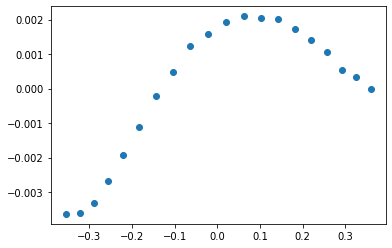

In [36]:
# Your turn!
mean_shape_Frechet=meanFrechet(complex_preshapes)
plt.scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
plt.show()

**2.3** Using the pairwise alignment routine you wrote in 1.2, align the whole dataset onto the Fréchet mean.

In [13]:
# Your turn!
aligned_shapes=np.zeros(preshapes.shape)

reference=np.stack((mean_shape_Frechet.real,mean_shape_Frechet.imag),axis=1)
for i in range(0,len(preshapes)):
    res=scipy.optimize.minimize(objectiveFunctionAlignment,0,args=(reference,preshapes[i]),method="L-BFGS-B")
    theta0=res.x[0]
    R=np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])
    aligned_shapes[i]=R.dot(preshapes[i].T).T

**2.4** Now that all shapes are aligned, compute the (point-by-point) mean shape of the dataset and visualize it. Does it differ from what you got in 2.2?

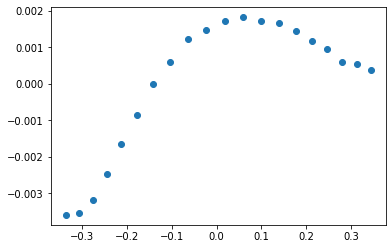

In [14]:
# Your turn!
mean_shape=np.mean(aligned_shapes,0)
plt.scatter(mean_shape[:,0],mean_shape[:,1])
plt.show()

**2.5** Repeat 2.3 and 2.4 by aligning the dataset onto a different, randomly chosen shape (e.g., the first one). Does the mean shape differ from what you got in 2.4? 

In [15]:
# Your turn!
# Align the whole dataset onto the first preshape
aligned_shapes_2=np.zeros(preshapes.shape)

reference=preshapes[0]
for i in range(0,len(preshapes)):
    res=scipy.optimize.minimize(objectiveFunctionAlignment,0,args=(reference,preshapes[i]),method="L-BFGS-B")
    theta0=res.x[0]
    R=np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])
    aligned_shapes_2[i]=R.dot(preshapes[i].T).T

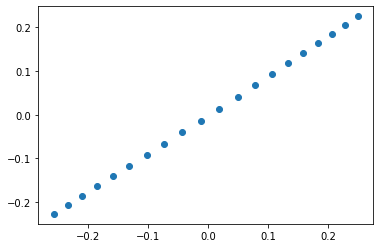

In [16]:
# Your turn!
mean_shape_2=np.mean(aligned_shapes_2,0)
plt.scatter(mean_shape_2[:,0],mean_shape_2[:,1])
plt.show()

**2.3** Pick one random shapes in the dataset. Relying on the function ``geodesicPath`` below, compute the geodesic path between this shape and the Fréchet mean, and visualize elements along the path.

In [37]:
def hermitianProduct(z,w):
    '''Hermitian product of z and w in the space of complex landmark configurations.'''
    return z.conj().T @ np.eye(len(z)) @ w

def geodesicDistance(z,w): 
    '''Geodesic distance between [z] and [w].'''
    aux=np.abs(hermitianProduct(z,w))
    if aux>1.0: 
        aux=1.0
    return np.arccos(aux)

def geodesicPath(z,w,numSteps): 
    '''Returns elements regularly spaced along the geodesic curve joining z to w (preshapes).'''
    ro = geodesicDistance(z,w)
    steps = np.arange(numSteps+1)/numSteps

    ta = np.angle(hermitianProduct(z,w))
    path = 1/np.sin(ro)*(np.sin((1-steps[:,None])*ro)*np.exp(1j*ta)*z + np.sin(steps[:,None]*ro)*w)
    return path

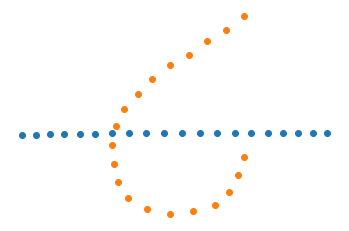

In [58]:
# Your turn!
# Pick two random complex preshapes and visualize them
random=np.random.choice(len(complex_preshapes)-1, size=1, replace=False)[0]
plt.scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
plt.scatter(complex_preshapes[random].real,complex_preshapes[random].imag)
plt.axis('off')
plt.show()

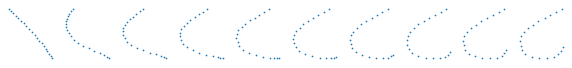

In [59]:
# Compute N steps along the geodesic path
steps=10
path=geodesicPath(mean_shape_Frechet,complex_preshapes[random],steps)

fig, ax = plt.subplots(1,steps, figsize=(steps,1))
for i in range(0,steps):
    ax[i].scatter(path[i].real,path[i].imag, s=.5)
    ax[i].axis('off')

**2.4** Compare the length of the above geodesics with the Procrustes distance. What do you observe? How does it relate to your findings in 2.2?

**TODO TODO TODO**

In [20]:
def fullDistance(z,w): # preshapes
    '''Full distance between [z] and [w]
    min_{alpha,theta} ||alpha e^{i theta} z - w||
                    = || w - P_z w || = ||z - P_w z|| \in [0,1] '''
    return np.sqrt(1.0 - np.abs(z.conj().T @ w)**2)

In [62]:
geo_distance=geodesicDistance(mean_shape_Frechet,complex_preshapes[random])
procrustes_distance=fullDistance(mean_shape_Frechet,complex_preshapes[random])

print(geo_distance)
print(procrustes_distance)

0.6587200060944814
0.6121051647473548


In [67]:
N=complex_preshapes.shape[1]
SQ = complex_preshapes.T @ complex_preshapes.conj() @ np.eye(N)
D,V = np.linalg.eig(SQ)
ds = np.real(D)
ind_max = np.argmax(ds)
ds_max = np.max(ds)

a=ds_max/len(complex_preshapes)

In [68]:
ref=np.stack((mean_shape_Frechet.real,mean_shape_Frechet.imag),axis=1)
aligned=np.stack((complex_preshapes[random].real,complex_preshapes[random].imag),axis=1)

np.linalg.norm(aligned_shapes[random]-a*ref)


0.6279462883915536

### 3. Shape space PCA

**3.1** Perform PCA in the tangent place around the Fréchet mean, using the logarithmic and exponential maps appropriately.

*Hint:*

**3.2** Visualize the two first modes of shape variation (PC 1 and PC 2). What happens if you don’t use the exponential and logarithmic maps? Do you understand why? 

**3.3** Plot the dataset by log-mapping around the Fréchet mean. What does it tell us about the dataset?

### 4. Statistical shape modelling

**4.1** Using the mean shape and covariance matrix of the dataset, build a simple statistical shape model (multivariate Gaussian).

*Hint:*


**4.2** Using your statistical model, generate a collection of synthetic shapes. How good do you think this model is? Why?

*Hint:*